# 详细项目请移步： https://github.com/yuhangz/cv_task

<img src="https://img.shields.io/badge/python-blue?&style=for-the-badge&logo=python&logoColor=white" style="margin-right: 0.25rem"/> <img src="https://img.shields.io/badge/jupyter notebook-orange?&style=for-the-badge&logo=python&logoColor=white" style="margin-right: 0.25rem"/>

In [ ]:

# 下面是 python 得内建库
# 导入functools库中的reduce函数，该函数将一个二元操作符应用于序列的项，将其规约到单个值  
from functools import reduce  
  
# 导入operator库，它提供了一系列内置的运算符函数  
import operator  
  
# 导入copy库，提供了浅拷贝和深拷贝对象的方法  
import copy  
  
# 导入time库，提供了与时间相关的各种函数  
import time

# 导入shutil库，提供了高级文件操作功能，如复制、删除目录和文件  
import shutil

# 基本的库，用于操作文件系统和系统路径
import os

# 导入PyTorch库，PyTorch是一个用于深度学习的开源库  
import torch  
  
# 导入PyTorch中的神经网络模块，提供了构建神经网络所需的各种层  
import torch.nn as nn  
  
# 导入PyTorch中的优化器模块，提供了各种优化算法如SGD, Adam等  
import torch.optim as optim  
  
# 导入PyTorch中的功能函数模块，提供了一系列激活函数、损失函数等  
import torch.nn.functional as F  
  
# 从PyTorch的utils模块中导入SummaryWriter，用于TensorBoard的日志记录  
from torch.utils.tensorboard import SummaryWriter  
  
# 从PyTorch的优化器模块中导入学习率调度器，如StepLR和ExponentialLR  
from torch.optim.lr_scheduler import StepLR, ExponentialLR  
  
# 从torchvision库中导入datasets和transforms模块  
# torchvision是PyTorch的一个扩展库，提供了计算机视觉相关的数据集、模型和图像转换工具  
from torchvision import datasets, transforms  
  
# 导入yaml库，用于读取和写入YAML格式的文件  
import yaml  
  
# 导入matplotlib的pyplot模块，用于绘制图表和可视化数据  
import matplotlib.pyplot as plt  
  
# 导入numpy库，一个强大的科学计算库，提供了多维数组对象、数学函数等  
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

In [2]:
# load the configuration
with open('config/config_mlp.yaml', 'r') as f:
    config = yaml.safe_load(f)

# get the configuration parameters
hidden_layers = config['model']['hidden_layers']
activation_function = config['model']['activation_function']
use_batch_norm = config['model']['use_batch_norm']
dropout_rate = config['model']['dropout_rate']
regularization = config['model']['regularization']
l1_lambda = config['model']['l1_lambda']
l2_lambda = config['model']['l2_lambda']
optimizer_type = config['optimizer']['type']
learning_rate = config['optimizer']['learning_rate']
lr_scheduler = config['optimizer']['lr_scheduler']
step_size = config['optimizer']['step_size']
gamma = config['optimizer']['gamma']
input_size = config['model']['input_size']
output_size = config['model']['output_size']
batch_size = config['batch_size']

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.EMNIST(root='./data',split='balanced', train=True,
                                   download=True, transform=transform)
test_data = datasets.EMNIST(root='./data',split='balanced', train=False,
                                  download=True, transform=transform)
print("the number of train data samples: ", len(train_data))
print("the number of test data samples: ", len(test_data))

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

the number of train data samples:  112800
the number of test data samples:  18800


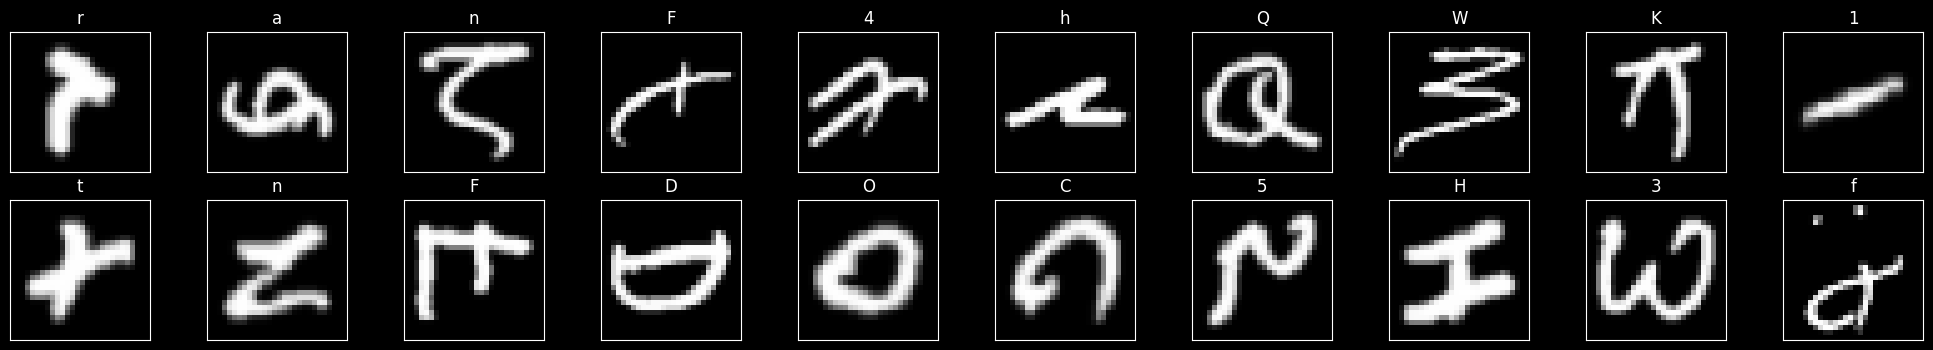

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)

images, labels = dataiter.__next__()
images = images.numpy()

 # emnist-balanced-mapping.txt 
with open('data/EMNIST/processed/emnist-balanced-mapping.txt') as f: 
    lines = f.readlines()
    
label_dict = {}
for row in lines:
    list1 = row.split(' ')
    label_dict[int(list1[0])] = chr(int(list1[1]))   #索引值 (list1[0])  对应 ASCII code (list1[1])

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(label_dict.get(labels[idx].item())))

In [4]:
img = np.squeeze(images[0])
width, height = img.shape
print(width, height)


28 28


In [5]:
# define the activation function
if activation_function == 'ReLU':
    activation = nn.ReLU()
elif activation_function == 'LeakyReLU':
    activation = nn.LeakyReLU()
elif activation_function == 'ELU':
    activation = nn.ELU()


# define the model
layers = [nn.Flatten()]
for i in range(len(hidden_layers)):
    if i == 0:
        layers.append(nn.Linear(input_size, hidden_layers[i]))
    else:
        layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
    layers.append(activation)
    layers.append(nn.BatchNorm1d(hidden_layers[i])) if use_batch_norm else nn.Identity(),
    layers.append(nn.Dropout(dropout_rate)) if dropout_rate else nn.Identity(),
layers.append(nn.Linear(hidden_layers[-1], output_size))
model = nn.Sequential(*layers)
print(model)

# define the optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
elif optimizer_type == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'AdaGrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)


# define the learning rate scheduler
if lr_scheduler == 'StepLR':
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
elif lr_scheduler == 'ExponentialLR':
    scheduler = ExponentialLR(optimizer, gamma=gamma)

# define the loss function
if regularization == 'L1':
    criterion = nn.CrossEntropyLoss() # or whatever loss function you are using
    def loss_function(output, target):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return criterion(output, target) + l1_lambda * l1_norm
elif regularization == 'L2':
    criterion = nn.CrossEntropyLoss()  # or whatever loss function you are using
    def loss_function(output, target):
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        return criterion(output, target) + l2_lambda * l2_norm
else:
    loss_function = nn.CrossEntropyLoss()  # or whatever loss function you are using

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=128, out_features=47, bias=True)
)


In [6]:
# number of epochs to train the model

log_time = time.time()

n_epochs = config['n_epochs']  # suggest training between 20-50 epochs

log_dir = f"hidden_layers_{'_'.join(map(str, hidden_layers))}_activation_{activation_function}_{log_time}"

# create the SummaryWriter
writer = SummaryWriter(f'runs/MLP/{log_dir}')
shutil.copy('config/config_mlp.yaml', f'runs/MLP/{log_dir}/config.yaml')

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.train() # prep model for training

losses = []
accs = []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running trainngi loss
        train_loss += loss.item() * data.size(0)
        # scheduler.step()
        
        with torch.no_grad():
            predict = output.argmax(1).cpu()
            acc = accuracy_score(target.cpu(), predict)
            
        losses.append(loss.item())
        accs.append(acc)
    
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    writer.add_scalar('Training Loss', train_loss, epoch)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
    writer.close()

CUDA is available!  Training on GPU ...
Epoch: 1 	Training Loss: 0.939943
Epoch: 2 	Training Loss: 0.546892
Epoch: 3 	Training Loss: 0.456665
Epoch: 4 	Training Loss: 0.401203
Epoch: 5 	Training Loss: 0.359499
Epoch: 6 	Training Loss: 0.324757
Epoch: 7 	Training Loss: 0.296741
Epoch: 8 	Training Loss: 0.273118
Epoch: 9 	Training Loss: 0.253873
Epoch: 10 	Training Loss: 0.237760
Epoch: 11 	Training Loss: 0.224503
Epoch: 12 	Training Loss: 0.212151
Epoch: 13 	Training Loss: 0.201583
Epoch: 14 	Training Loss: 0.193561
Epoch: 15 	Training Loss: 0.186517
Epoch: 16 	Training Loss: 0.181323
Epoch: 17 	Training Loss: 0.174046
Epoch: 18 	Training Loss: 0.168657
Epoch: 19 	Training Loss: 0.164857
Epoch: 20 	Training Loss: 0.159474


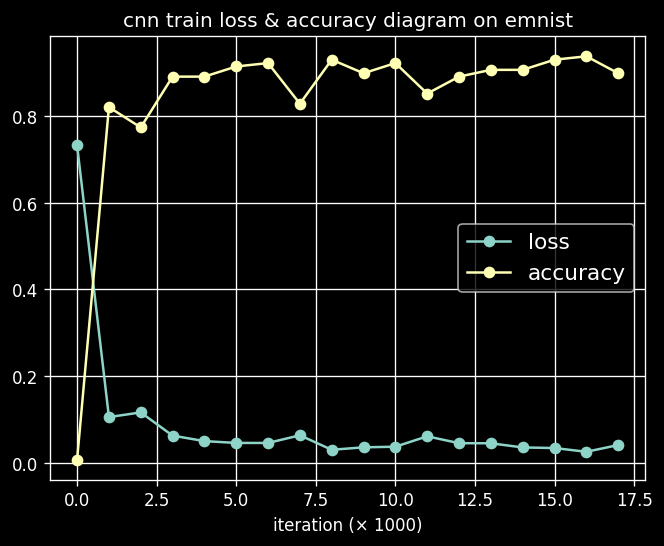

In [7]:
# 绘制训练的loss-acc函数
losses = np.array(losses)
accs = np.array(accs)
indices = np.arange(losses.__len__())
losses = losses / losses.max()

plt.figure(dpi=120)
plt.plot(losses[indices % 1000 == 0], '-o', label='loss')
plt.plot(accs[indices % 1000 == 0], '-o', label='accuracy')
plt.xlabel('iteration (× 1000)')
plt.grid(True)
plt.legend(fontsize=13)
plt.title('cnn train loss & accuracy diagram on emnist')
plt.savefig('../figure/mlp.train.png')

In [8]:
test_loss = 0.0
class_correct = list(0. for i in range(47))
class_total = list(0. for i in range(47))

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.eval() # prep model for *evaluation*

six_samples = []
predict_labels = []
gt_labels = []


for data, target in test_loader:
    with torch.no_grad():
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        predict = output.argmax(1)
        predict_labels.extend(list(predict.cpu()))
        gt_labels.extend(list(target.cpu()))
        
        if len(six_samples) == 0:
            six_samples.extend(list(data[:6].cpu()))

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        # calculate test accuracy for each object class
        for i in range(len(target.data)):  # change here
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1



for i in range(47):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), accuracy,
            np.sum(class_correct[i]), np.sum(class_total[i])))

overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    overall_accuracy,
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of     0: 53% (212/400)
Test Accuracy of     1: 63% (255/400)
Test Accuracy of     2: 81% (325/400)
Test Accuracy of     3: 90% (361/400)
Test Accuracy of     4: 84% (336/400)
Test Accuracy of     5: 85% (341/400)
Test Accuracy of     6: 91% (364/400)
Test Accuracy of     7: 93% (375/400)
Test Accuracy of     8: 85% (340/400)
Test Accuracy of     9: 81% (324/400)
Test Accuracy of    10: 93% (372/400)
Test Accuracy of    11: 91% (365/400)
Test Accuracy of    12: 95% (381/400)
Test Accuracy of    13: 85% (342/400)
Test Accuracy of    14: 92% (370/400)
Test Accuracy of    15: 56% (226/400)
Test Accuracy of    16: 85% (340/400)
Test Accuracy of    17: 92% (370/400)
Test Accuracy of    18: 56% (226/400)
Test Accuracy of    19: 91% (365/400)
Test Accuracy of    20: 92% (369/400)
Test Accuracy of    21: 53% (213/400)
Test Accuracy of    22: 97% (390/400)
Test Accuracy of    23: 93% (374/400)
Test Accuracy of    24: 75% (300/400)
Test Accuracy of    25: 93% (374/400)
Test Accurac

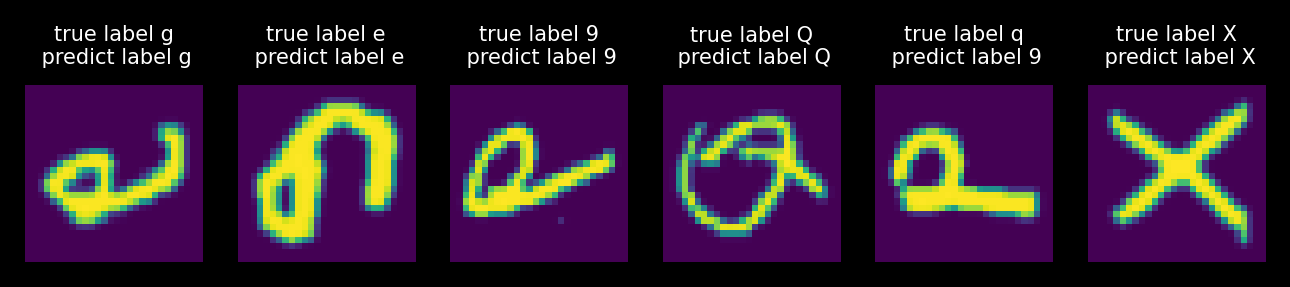

In [9]:
# 绘制 test 的前 6 个样本的预测结果
plt.figure(dpi=250)
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(six_samples[i][0])
    plt.title('true label {}\n predict label {}'.format(label_dict[gt_labels[i].item()], label_dict[predict_labels[i].item()]), fontsize=6)
    plt.grid(False)
    plt.axis('off')
plt.savefig('../figure/mlp.test.sample.png')

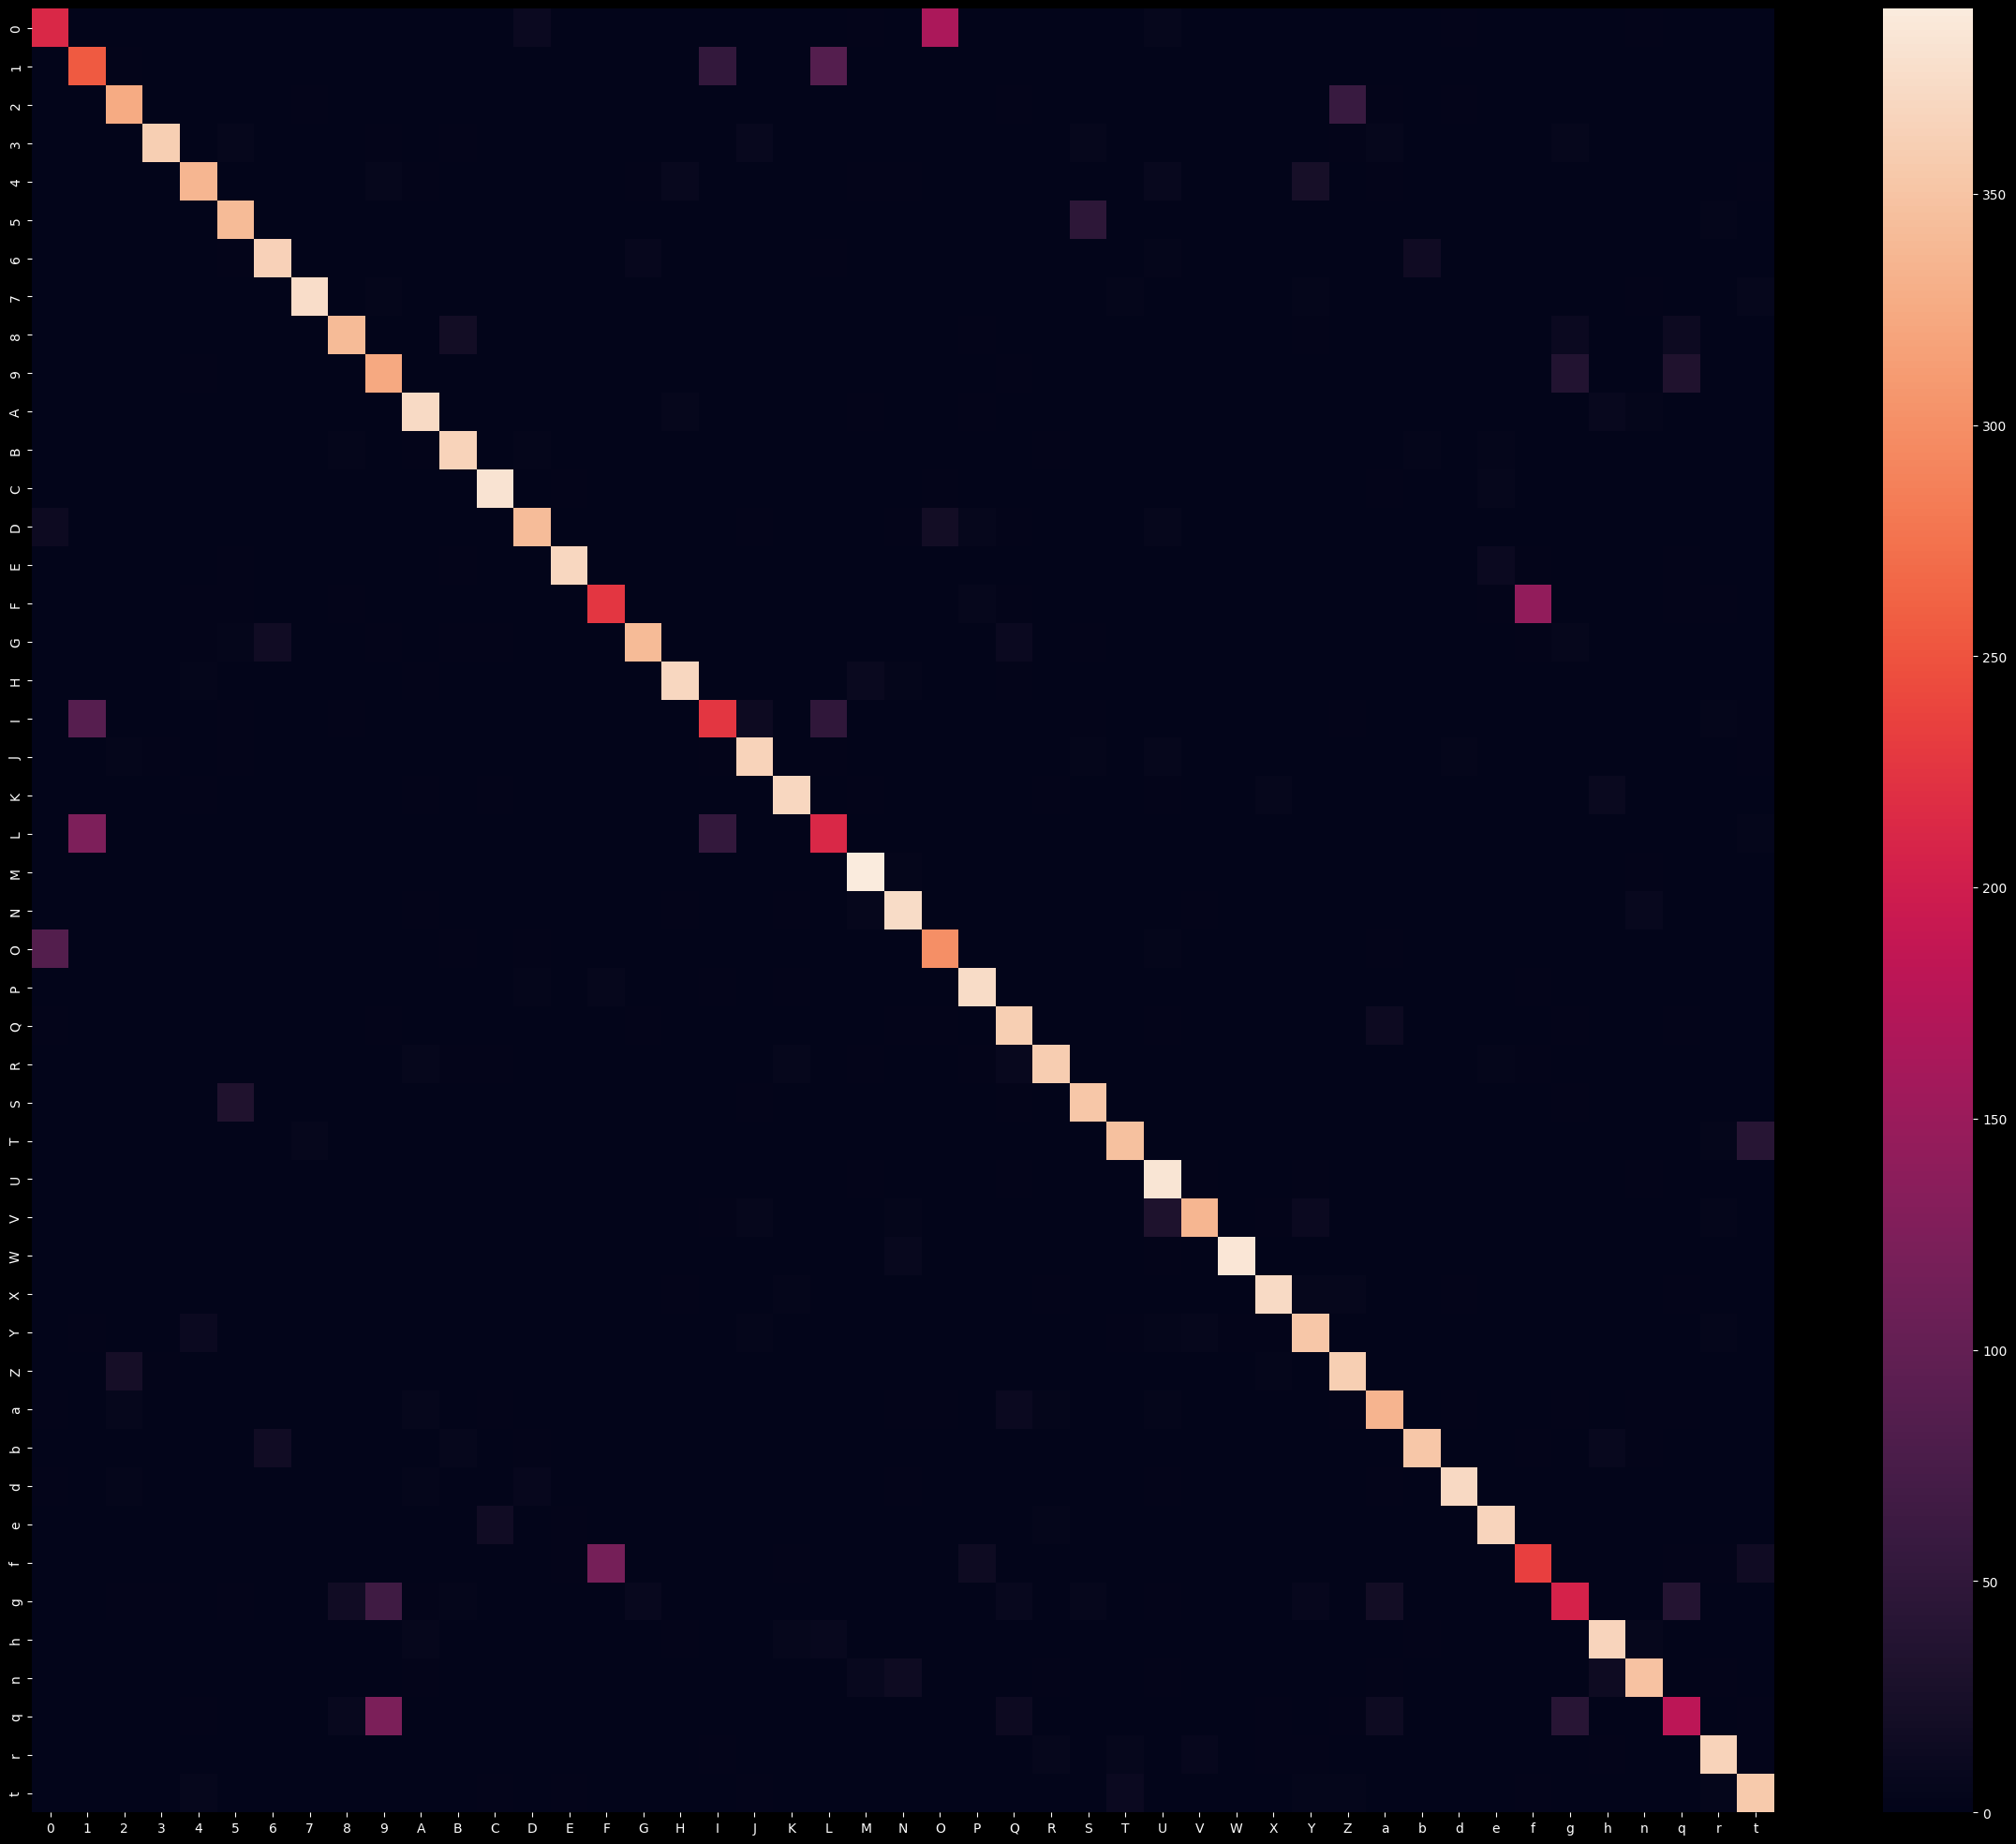

In [10]:
# 绘制混淆矩阵
plt.figure(figsize=(30, 25))

import seaborn
tick_labels = label_dict.values()
seaborn.heatmap(
    confusion_matrix(gt_labels, predict_labels),
    xticklabels=tick_labels,
    yticklabels=tick_labels,
)
plt.savefig('../figure/mlp.test.confusion-matrix.png')

In [11]:
print(accuracy_score(gt_labels, predict_labels))
print(classification_report(gt_labels, predict_labels))

0.835
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       400
           1       0.54      0.64      0.59       400
           2       0.87      0.81      0.84       400
           3       0.98      0.90      0.94       400
           4       0.90      0.84      0.87       400
           5       0.85      0.85      0.85       400
           6       0.90      0.91      0.91       400
           7       0.96      0.94      0.95       400
           8       0.89      0.85      0.87       400
           9       0.61      0.81      0.69       400
          10       0.89      0.93      0.91       400
          11       0.90      0.91      0.90       400
          12       0.91      0.95      0.93       400
          13       0.90      0.85      0.88       400
          14       0.96      0.93      0.94       400
          15       0.63      0.56      0.60       400
          16       0.93      0.85      0.89       400
          17       0.

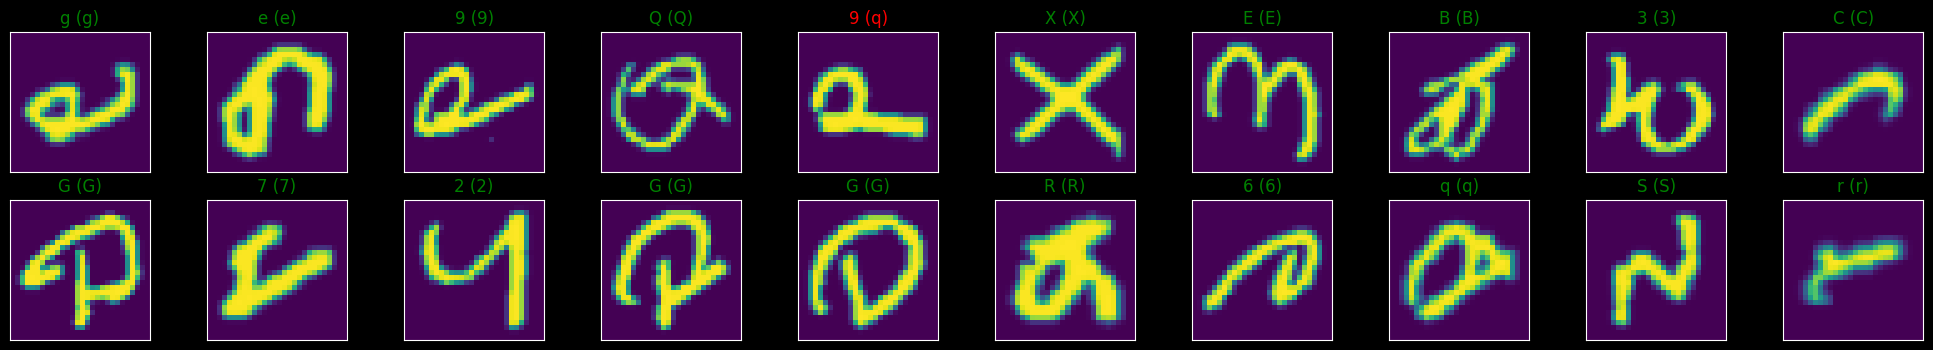

In [12]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# move images and labels to GPU if CUDA is available
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# move images and preds back to CPU for displaying images and numpy operations
if train_on_gpu:
    images, preds = images.cpu(), preds.cpu()

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='viridis')
    ax.set_title("{} ({})".format(str(label_dict.get(preds[idx].item())), str(label_dict.get(labels[idx].item()))),
                 color=("green" if preds[idx]==labels[idx] else "red"))